# Example: Using the Driver Class

The previous examples show the main components of the xesn package. However, there are a number of common workflows like readout matrix training, testing, and macro parameter optimization. The [xesn.Driver](generated/xesn.Driver.rst) was designed to orchestrate these common workflows in a simple and reproducible way. The Driver class does the following:

- Uses a single yaml file to facilitate the experimental design, rather than relying on recreating many nested dictionaries in code or notebooks (although dictionaries can also be used)

- Implements a streamlined interface that is convenient for batch jobs (e.g., HPC schedulers or cloud deployment)

- Stores results and timing information in a single directory for each experiment

In this example we'll repeat the key steps of the [macro_training](example_macro_training.ipynb) example using the Driver class.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr

In [2]:
plt.style.use("./xesn.mplstyle")

## Create training, macro training, and testing data

Because the Driver class expects data to be in [zarr](https://zarr.readthedocs.io/en/stable/) format, we'll create the data and store it here.
Note that we don't create separate zarr stores for the training and testing phases, but instead provide these indices to the Driver within the config yaml file, see next section.

In [3]:
from lorenz import Lorenz96

In [4]:
model = Lorenz96(N=12)

In [5]:
n_spinup = 2_000
n_train = 40_000
n_macro_training = 10_000
n_transient = 5_000
n_test = 10_000

n_total = n_spinup+n_train+n_macro_training+n_transient + n_test
rs = np.random.RandomState(1)
trajectory = model.generate(n_steps=n_total, x0=rs.normal(size=(model.N,)))

In [6]:
trajectory.to_dataset(name="trajectory").to_zarr("./lorenz96-12d.zarr", mode="w")

We don't normalize the data here, since this is done within the Driver, using the
[xesn.XData](generated/xesn.XData.rst) class.

## The Configuration yaml file

The Driver class operates with a single yaml file that configures its experiments.
For this example, we will use this [config.yaml](config.yaml) file.
The options set in this file should look familiar to the options set in the various dictionaries in [the macro training example](example_macro_training.ipynb).

## Train and Test an ESN with a Guessed Parameter Set

In the `esn` section of the config file, we've set the same macro parameters for our "guess" trajectory in the previous example.
To get those results, we create a driver, train the ESN, and test it.

Note that if we were using a `LazyESN`, this section would have to be labelled as such.

In [7]:
from xesn import Driver

In [8]:
driver = Driver(config="config.yaml", output_directory="output-guess")
driver

Creating directory for output:  output-guess


Driver
    output_directory:           output-guess
    logfile:                    output-guess/stdout.log

In [9]:
%%time
driver.run_training()

CPU times: user 41.2 s, sys: 1.46 s, total: 42.6 s
Wall time: 3.94 s


In [10]:
%%time
driver.run_test()

CPU times: user 57.5 s, sys: 2.99 s, total: 1min
Wall time: 6.4 s


Now we can look in `driver.output_directory` and see:

- a copied `config.yaml` file for reference and future use

- trained ESN weights in a zarr store

- the logfile with timing and basic information for reference

- the test results in a single zarr store

In [11]:
!ls output-guess/

config.yaml       esn-weights.zarr  stdout.log        test-results.zarr


We'll look at the results later after we have the optimized configuration

## Run Macro Training

This uses the `macro_training` section of the yaml file, and note how the options in that section correspond to the macro_training dict created in [the previous example](example_macro_training.ipynb#The-config-dictionary), along with options passed to [xesn.optimize](generated/xesn.optimize.rst).

A detail here is that when we run `driver.run_test` it looks for weights based on the value in the `esn_weights` section of the yaml file.
Because the config file was set up knowing that we would put the first weights in the `output-guess` directory, we will want to change this option.
In general, any option can be changed after reading in the yaml file by using the
[Driver.overwrite_config](generated/xesn.Driver.overwrite_config.rst) method.
This is useful for running parameter sweeps with a single yaml file and a simple python module.

In [12]:
optim_driver = Driver(config="config.yaml", output_directory="output-optim")
optim_driver.overwrite_config({
    "esn_weights": {"store": f"{optim_driver.output_directory}/esn-weights.zarr"}
})

Creating directory for output:  output-optim


In [13]:
%%time
optim_driver.run_macro_training()

/Users/tsmith/work/xesn/xesn/esn.py:514: LinAlgWarning: Ill-conditioned matrix (rcond=6.14587e-21): result may not be accurate.
  Wout = solve(rbar.T, ybar.T, **kw)
/Users/tsmith/work/xesn/xesn/esn.py:514: LinAlgWarning: Ill-conditioned matrix (rcond=3.11019e-18): result may not be accurate.
  Wout = solve(rbar.T, ybar.T, **kw)


CPU times: user 30min 27s, sys: 57.9 s, total: 31min 25s
Wall time: 3min 4s


Note that after optimization, the driver config automatically gets overwritten with these optimal parameters so that we can start using them immediately.

In [14]:
print(optim_driver.config["esn"]["adjacency_kwargs"]["factor"])
print(optim_driver.config["esn"]["input_kwargs"]["factor"])
print(optim_driver.config["esn"]["bias_kwargs"]["factor"])
print(optim_driver.config["esn"]["leak_rate"])
print(optim_driver.config["esn"]["tikhonov_parameter"])

1.6500000000000001
0.35000000000000003
1.75
0.42500000000000004
1.2589254117941662e-10


For future reference, the optimal parameter values are in the logfile, or in the newly created config-optim.yaml file

In [15]:
!ls output-optim/

config-optim.yaml config.yaml       stdout.log


In [16]:
!tail -n 20 output-optim/stdout.log

Optimal inputs:
	input_factor                : 0.35000000000000003
	adjacency_factor            : 1.6500000000000001
	bias_factor                 : 1.75
	leak_rate                   : 0.42500000000000004
	tikhonov_parameter          : 1.2589254117941662e-10

Approximate cost minimum:
	[1.14570865]

Elapsed time: 184.3283 seconds

Driver.overwrite_config: Overwriting driver.config['esn']['input_kwargs']['factor'] with 0.35000000000000003
Driver.overwrite_config: Overwriting driver.config['esn']['adjacency_kwargs']['factor'] with 1.6500000000000001
Driver.overwrite_config: Overwriting driver.config['esn']['bias_kwargs']['factor'] with 1.75
Driver.overwrite_config: Overwriting driver.config['esn']['leak_rate'] with 0.42500000000000004
Driver.overwrite_config: Overwriting driver.config['esn']['tikhonov_parameter'] with 1.2589254117941662e-10
Optimal configuration written to output-optim/config-optim.yaml
Elapsed time: 184.3883 seconds



In [17]:
!grep -A 22 "esn:" output-optim/config-optim.yaml

esn:
  adjacency_kwargs:
    connectedness: 5
    distribution: uniform
    factor: 1.6500000000000001
    is_sparse: true
    normalization: svd
    random_seed: 1
  bias_kwargs:
    distribution: uniform
    factor: 1.75
    random_seed: 2
  input_kwargs:
    distribution: uniform
    factor: 0.35000000000000003
    is_sparse: false
    normalization: svd
    random_seed: 0
  leak_rate: 0.42500000000000004
  n_input: 12
  n_output: 12
  n_reservoir: 1000
  tikhonov_parameter: 1.2589254117941662e-10


<div class="alert alert-info">

Note:

The macro training only gives us the optimal scalar parameters we wanted, and unfortunately does not provide us with the readout weights that go along with those scalar parameters.
This means we have to rerun the readout matrix training after we've finished the macro training.
 
</div>

In [18]:
%%time
optim_driver.run_training()

CPU times: user 46.1 s, sys: 1.41 s, total: 47.6 s
Wall time: 4.17 s


/Users/tsmith/work/xesn/xesn/esn.py:514: LinAlgWarning: Ill-conditioned matrix (rcond=3.11019e-18): result may not be accurate.
  Wout = solve(rbar.T, ybar.T, **kw)


In [19]:
%%time
optim_driver.run_test()

CPU times: user 1min 1s, sys: 2.05 s, total: 1min 3s
Wall time: 6.81 s


### Read in Test Results

In [20]:
ds = xr.open_zarr(f"{driver.output_directory}/test-results.zarr")
ds = ds.rename({
    "prediction": "guess",
    "nrmse": "nrmse_guess",
    "psd_prediction": "psd_guess",
    "psd_nrmse": "psd_nrmse_guess",
})

In [21]:
ods = xr.open_zarr(f"{optim_driver.output_directory}/test-results.zarr")
ds["optimized"] = ods["prediction"]
ds["psd_optimized"] = ods["psd_prediction"]
ds["nrmse_optimized"] = ods["nrmse"]
ds["psd_nrmse_optimized"] = ods["psd_nrmse"]

## Visualize the Optimized and Guessed ESN Performance on the Test Datasets

In [22]:
import seaborn as sns

In [31]:
def plot_visual_comparison(xds, varnames, sample):
    
    nrows = len(xds.x)
    fig, axs = plt.subplots(nrows, 1, figsize=(8, nrows*1), constrained_layout=True, sharex=True, sharey=True)
    
    for i, ax in enumerate(axs):
        for key in varnames:
            color = "k" if key == "truth" else None
            xds[key].isel(x=i, sample=sample).plot(ax=ax, color=color, label=key)
        ax.set(ylabel="", xlabel="", title="")
    ax.set(xlabel="Forecast Time (MTU)", ylim=(-8,13))
    axs[0].legend(loc=(.25,.87),ncol=3)

In [32]:
def plot_metrics(xds, varnames):
    
    fig, axs = plt.subplots(1, 2, figsize=(8,4), constrained_layout=True)

    ekeys = list(v for v in varnames if v != "truth")
    for key in ekeys:
        ekey = f"nrmse_{key}"
        sns.lineplot(
            data=xds[ekey].to_dataset(name="NRMSE").to_dataframe().reset_index(),
            x="ftime",
            y="NRMSE",
            ax=axs[0],
            label=key,
        )
    for key in varnames:
        pkey = f"psd_{key}"
        sns.lineplot(
            data=xds[pkey].to_dataset(name="PSD").to_dataframe().reset_index(),
            x="k1d",
            y="PSD",
            ax=axs[1],
            color="k" if "truth" in key else None,
            label=key,
        )
    axs[0].set(ylim=(-.1, 2), xlabel="Forecast Time (MTU)")
    axs[0].axhline(y=.2, color="gray")
    axs[1].set(yscale="log", xlabel="Wavenumber Index")
    [ax.legend() for ax in axs];
    return fig, axs

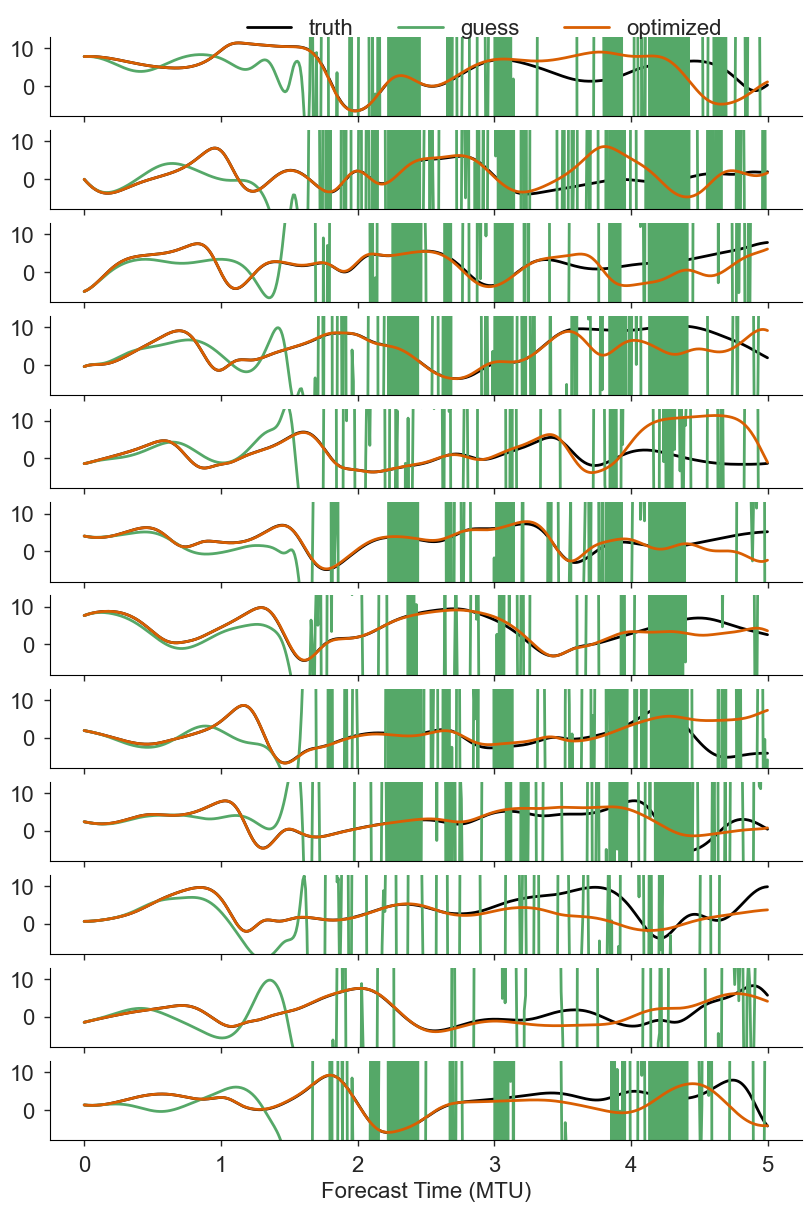

In [33]:
plot_visual_comparison(ds, varnames=["truth", "guess", "optimized"], sample=0)

Now compare NRMSE and PSD over the test samples 

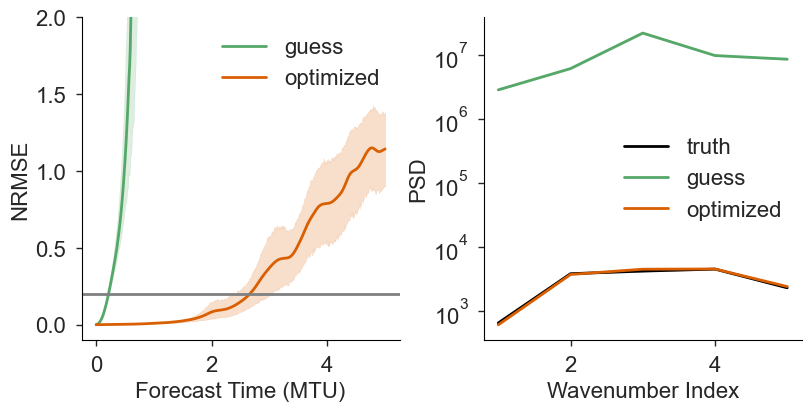

In [26]:
plot_metrics(ds, varnames=["truth", "guess", "optimized"]);

## Cleanup

In [34]:
from shutil import rmtree

In [35]:
rmtree("lorenz96-12d.zarr")
rmtree(driver.output_directory)
rmtree(optim_driver.output_directory)

## Potential Areas of Future Development

- Right now [xesn.XData](generated/xesn.XData.rst), and therefore the Driver class, expects data to be stored in zarr. This could be changed so that it takes data in memory for "online" experiments

- Currently XData and Driver are designed to use a single zarr store with indices for training, macro_training, and testing. This could be generalized to more automatically work with entirely different datasets.

- The normalization procedure in [XData.normalize](generated/xesn.XData.normalize.rst) is extremely basic, and could be hooked up with other packages like scikit-learn in order to provide more general routines.